In [1]:
# !pip install kaggle
# from google.colab import files
# files.upload()

In [2]:
# !ls -1ha kaggle.json

In [3]:
from google.colab import drive

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
# !mkdir -p ~/.kaggle
# !cp kaggle.json ~/.kaggle/
# # Permission Warning 이 일어나지 않도록 
# !chmod 600 ~/.kaggle/kaggle.json
# # 본인이 참가한 모든 대회 보기 
# !kaggle competitions list

In [5]:
!pip3 install tokenizers wandb sentencepiece

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [6]:
!pip install transformers

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
import os
os.chdir("drive/")
os.chdir('My Drive')
os.chdir('Kaggle')

In [8]:
# !kaggle competitions download -c us-patent-phrase-to-phrase-matching
# !unzip us-patent-phrase-to-phrase-matching.zip
# !ls

In [9]:
# debert_v3_tokenizer_path = 'deberta-v2-v3-fast-tokenizer'
# %env TOKENIZERS_PARALLELISM=true

# import shutil
# from pathlib import Path

# transformers_path = Path('/usr/local/lib/python3.7/dist-packages/transformers')
# input_dir = Path('./deberta-v2-v3-fast-tokenizer')

# convert_file = input_dir / "convert_slow_tokenizer.py"
# conversion_path = transformers_path / convert_file.name

# if conversion_path.exists():
#     conversion_path.unlink()

# shutil.copy(convert_file, transformers_path)
# deberta_v2_path = transformers_path / "models" / "deberta_v2"

# for filename in ['tokenization_deberta_v2.py', 'tokenization_deberta_v2_fast.py']:
#     filepath = deberta_v2_path/filename
    
#     if filepath.exists():
#         filepath.unlink()
#     shutil.copy(input_dir/filename, filepath)

In [10]:
OUTPUT_DIR = './pppm-bert/'
if not os.path.exists(OUTPUT_DIR):
    os.makedirs(OUTPUT_DIR)

In [11]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue Jun 14 07:47:49 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    24W / 300W |      0MiB / 16160MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [12]:
# ====================================================
# CFG
# ====================================================
class CFG:
    wandb=True
    competition='PPPM'
    _wandb_kernel='bluehills'
    debug=False
    apex=True
    print_freq=100
    num_workers=4
    model="distilbert-base-uncased" # ['xlm-roberta-large', 'distilbert-base-uncased', 'sentence-transformers/distilbert-base-nli-mean-tokens']
    scheduler='cosine' # ['linear', 'cosine']
    batch_scheduler=True
    num_cycles=0.5
    num_warmup_steps=50 # [0, 50, 100]
    epochs=5
    encoder_lr=1.5e-5 #2e-5
    decoder_lr=1.5e-5 #2e-5
    min_lr=5e-7
    eps=5e-7
    betas=(0.9, 0.999)
    batch_size=16
    fc_dropout=0.15
    target_size=1
    max_len=512
    weight_decay=0.01
    gradient_accumulation_steps=1
    max_grad_norm=1000
    seed=41
    train_all_index=20
    n_fold=5
    trn_fold=[0, 1, 2, 3, 4, 5, 6, 7, 8, 9]
    train=True
    
if CFG.debug:
    CFG.epochs = 2
    CFG.trn_fold = [0]

In [13]:
# ====================================================
# wandb
# ====================================================
if CFG.wandb:
    import wandb
    try:
        # from kaggle_secrets import UserSecretsClient
        # user_secrets = UserSecretsClient()
        # secret_value_0 = user_secrets.get_secret("wandb_api")
        # wandb.login(key=secret_value_0)
        print('login to wandb')
        wandb.login()
        anony = None
    except:
        anony = "must"
        print('If you want to use your W&B account, go to Add-ons -> Secrets and provide your W&B access token. Use the Label name as wandb_api. \nGet your W&B access token from here: https://wandb.ai/authorize')


    def class2dict(f):
        return dict((name, getattr(f, name)) for name in dir(f) if not name.startswith('__'))

    run = wandb.init(project='PPPM-MSE', 
                     name=CFG.model,
                     config=class2dict(CFG),
                     group=CFG.model,
                     job_type="train",
                     anonymous=anony)

login to wandb


wandb: Currently logged in as: bluehills. Use `wandb login --relogin` to force relogin


# Library

In [14]:
# ====================================================
# Library
# ====================================================
import os
import gc
import re
import ast
import sys
import copy
import json
import time
import math
import shutil
import string
import pickle
import random
import joblib
import itertools
from pathlib import Path
import warnings
warnings.filterwarnings("ignore")

import scipy as sp
import numpy as np
import pandas as pd
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)
from tqdm.auto import tqdm
from sklearn.metrics import f1_score
from sklearn.model_selection import StratifiedKFold, GroupKFold, KFold
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedGroupKFold

import torch
print(f"torch.__version__: {torch.__version__}")
import torch.nn as nn
from torch.nn import Parameter
import torch.nn.functional as F
from torch.optim import Adam, SGD, AdamW
from torch.utils.data import DataLoader, Dataset
import torch.cuda.amp as amp

import tokenizers
import transformers
print(f"tokenizers.__version__: {tokenizers.__version__}")
print(f"transformers.__version__: {transformers.__version__}")
from transformers import AutoTokenizer, AutoModel, AutoConfig, AutoModelForSequenceClassification
from transformers import get_linear_schedule_with_warmup, get_cosine_schedule_with_warmup
from transformers import AutoTokenizer, AutoConfig, AutoModelForTokenClassification

%env TOKENIZERS_PARALLELISM=true

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

torch.__version__: 1.11.0+cu113
tokenizers.__version__: 0.12.1
transformers.__version__: 4.19.4
env: TOKENIZERS_PARALLELISM=true


In [15]:
from transformers import BartTokenizer, BartModel

# Utils

In [16]:
# ====================================================
# Utils
# ====================================================
def get_score(y_true, y_pred):
    score = sp.stats.pearsonr(y_true, y_pred)[0]
    return score


def get_logger(filename=OUTPUT_DIR+'train'):
    from logging import getLogger, INFO, StreamHandler, FileHandler, Formatter
    logger = getLogger(__name__)
    logger.setLevel(INFO)
    handler1 = StreamHandler()
    handler1.setFormatter(Formatter("%(message)s"))
    handler2 = FileHandler(filename=f"{filename}.log")
    handler2.setFormatter(Formatter("%(message)s"))
    logger.addHandler(handler1)
    logger.addHandler(handler2)
    return logger

LOGGER = get_logger()

def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

# Data Loading

In [17]:
# ====================================================
# Data Loading
# ====================================================
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
submission = pd.read_csv('sample_submission.csv')
print(f"train.shape: {train.shape}")
print(f"test.shape: {test.shape}")
print(f"submission.shape: {submission.shape}")
display(train.head())
display(test.head())
display(submission.head())

train.shape: (36473, 5)
test.shape: (36, 4)
submission.shape: (36, 2)


,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00


,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


,id,score
0,4112d61851461f60,0
1,09e418c93a776564,0
2,36baf228038e314b,0
3,1f37ead645e7f0c8,0
4,71a5b6ad068d531f,0


In [18]:
# ====================================================
# CPC Data
# ====================================================
def get_cpc_texts():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


def get_cpc_texts_nakama():
    contexts = []
    pattern = '[A-Z]\d+'
    for file_name in os.listdir('./CPCSchemeXML202105'):
        result = re.findall(pattern, file_name)
        if result:
            contexts.append(result)
    contexts = sorted(set(sum(contexts, [])))
    results = {}
    for cpc in ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'Y']:
        with open(f'./CPCTitleList202202/cpc-section-{cpc}_20220201.txt') as f:
            s = f.read()
        pattern = f'{cpc}\t\t.+'
        result = re.findall(pattern, s)
        cpc_result = result[0].lstrip(pattern)
        for context in [c for c in contexts if c[0] == cpc]:
            pattern = f'{context}\t\t.+'
            result = re.findall(pattern, s)
            results[context] = cpc_result + ". " + result[0].lstrip(pattern)
    return results


cpc_texts = get_cpc_texts()
# cpc_texts = get_cpc_texts_nakama()
torch.save(cpc_texts, OUTPUT_DIR+"cpc_texts.pth")
train['context_text'] = train['context'].map(cpc_texts)
test['context_text'] = test['context'].map(cpc_texts)
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...


,id,anchor,target,context,context_text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE


In [19]:
train['text'] = '[CLS]' + train['anchor'] + '[SEP]' + train['target'] + '[SEP]'  + train['context_text']
test['text'] = '[CLS]' + test['anchor'] + '[SEP]' + test['target'] + '[SEP]'  + test['context_text']
display(train.head())
display(test.head())

,id,anchor,target,context,score,context_text,text
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[SEP]abatement of pollution[SEP]...
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[SEP]act of abating[SEP]HUMAN NE...
2,36d72442aefd8232,abatement,active catalyst,A47,0.25,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[SEP]active catalyst[SEP]HUMAN N...
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[SEP]eliminating process[SEP]HUM...
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00,HUMAN NECESSITIES. FURNITURE; DOMESTIC ARTICLE...,[CLS]abatement[SEP]forest region[SEP]HUMAN NEC...


,id,anchor,target,context,context_text,text
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02,PHYSICS. OPTICS,[CLS]opc drum[SEP]inorganic photoconductor dru...
1,09e418c93a776564,adjust gas flow,altering gas flow,F23,MECHANICAL ENGINEERING; LIGHTING; HEATING; WEA...,[CLS]adjust gas flow[SEP]altering gas flow[SEP...
2,36baf228038e314b,lower trunnion,lower locating,B60,PERFORMING OPERATIONS; TRANSPORTING. VEHICLES ...,[CLS]lower trunnion[SEP]lower locating[SEP]PER...
3,1f37ead645e7f0c8,cap component,upper portion,D06,TEXTILES; PAPER. TREATMENT OF TEXTILES OR THE ...,[CLS]cap component[SEP]upper portion[SEP]TEXTI...
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04,ELECTRICITY. ELECTRIC COMMUNICATION TECHNIQUE,[CLS]neural stimulation[SEP]artificial neural ...


# EDA

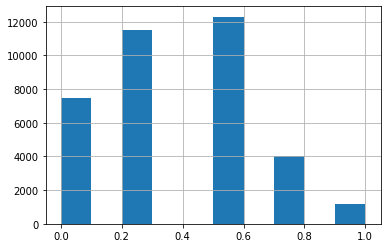

In [20]:
train['score'].hist()

In [21]:
display(train['context'].apply(lambda x: x[0]).value_counts())

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: context, dtype: int64

# CV Split

In [22]:
# ====================================================
# CV split
# ====================================================
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})
# Fold = StratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (train_index, val_index) in enumerate(Fold.split(train, train['score_map'])):
#     train.loc[val_index, 'fold'] = int(n)
# train['fold'] = train['fold'].astype(int)
# display(train.groupby('fold').size())

In [23]:
# train['score_map'] = train['score'].map({0.00: 0, 0.25: 1, 0.50: 2, 0.75: 3, 1.00: 4})

# encoder = LabelEncoder()
# train['anchor_map'] = encoder.fit_transform(train['anchor'])

# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)
# for n, (_, valid_index) in enumerate(kf.split(train, train['score_map'], groups=train['anchor_map'])):
#     train.loc[valid_index, 'fold'] = int(n)

# train['fold'] = train['fold'].astype(int)

In [24]:
# titles = pd.read_csv('./titles.csv')
# train = train.merge(titles, left_on='context', right_on='code')
# train['fold'] = -1
# kf = StratifiedGroupKFold(n_splits=CFG.n_fold, shuffle=True, random_state=CFG.seed)

# for f, (t_, v_) in enumerate(kf.split(X=train, y=train['anchor'], groups=train['anchor'])):
#     train.loc[v_, 'fold'] = f

# train['fold'].hist()
# train['text'] = train['anchor'] + '[SEP]' + train['title'].apply(str.lower)
# train = train[['id','anchor', 'target', 'context', 'score', 'title', 'fold', 'text']]

In [25]:
!pip3 install -q iterative-stratification
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

dfx = pd.get_dummies(train, columns=["score"]).groupby(["anchor"], as_index=False).sum()
cols = [c for c in dfx.columns if c.startswith("score_") or c == "anchor"]
dfx = dfx[cols]

mskf = MultilabelStratifiedKFold(n_splits=CFG.n_fold, shuffle=True, random_state=42)
labels = [c for c in dfx.columns if c != "anchor"]
dfx_labels = dfx[labels]
dfx["fold"] = -1

for fold, (trn_, val_) in enumerate(mskf.split(dfx, dfx_labels)):
    print(len(trn_), len(val_))
    dfx.loc[val_, "fold"] = fold

train = train.merge(dfx[["anchor", "fold"]], on="anchor", how="left")
print(train.fold.value_counts())

587 146
587 146
586 147
586 147
586 147
2    7683
0    7592
3    7324
1    6995
4    6879
Name: fold, dtype: int64


In [26]:
if CFG.debug:
    display(train.groupby('fold').size())
    train = train.sample(n=1000, random_state=0).reset_index(drop=True)
    display(train.groupby('fold').size())

# Tokenizer

In [27]:
# ====================================================
# tokenizer
# ====================================================
tokenizer = AutoTokenizer.from_pretrained(CFG.model)
tokenizer.save_pretrained(OUTPUT_DIR+'tokenizer/')
CFG.tokenizer = tokenizer

# Dataset

In [28]:
# ====================================================
# Define max_len
# ====================================================
lengths_dict = {}

lengths = []
tk0 = tqdm(cpc_texts.values(), total=len(cpc_texts))
for text in tk0:
    length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
    lengths.append(length)
lengths_dict['context_text'] = lengths

for text_col in ['anchor', 'target']:
    lengths = []
    tk0 = tqdm(train[text_col].fillna("").values, total=len(train))
    for text in tk0:
        length = len(tokenizer(text, add_special_tokens=False)['input_ids'])
        lengths.append(length)
    lengths_dict[text_col] = lengths
    
CFG.max_len = max(lengths_dict['anchor']) + max(lengths_dict['target'])\
                + max(lengths_dict['context_text']) + 4 # CLS + SEP + SEP + SEP
LOGGER.info(f"max_len: {CFG.max_len}")

  0%|          | 0/136 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

  0%|          | 0/36473 [00:00<?, ?it/s]

max_len: 125


In [29]:
# ====================================================
# Dataset
# ====================================================
def prepare_input(cfg, text):
    inputs = cfg.tokenizer(text,
                           add_special_tokens=True,
                           max_length=cfg.max_len,
                           padding="max_length",
                           return_offsets_mapping=False)
    for k, v in inputs.items():
        inputs[k] = torch.tensor(v, dtype=torch.long)
    return inputs


class TrainDataset(Dataset):
    def __init__(self, cfg, df):
        self.cfg = cfg
        self.texts = df['text'].values
        self.labels = df['score'].values

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, item):
        inputs = prepare_input(self.cfg, self.texts[item])
        label = torch.tensor(self.labels[item], dtype=torch.float)
        return inputs, label

In [30]:
"""
train_dataset = TrainDataset(CFG, train)
inputs, label = train_dataset[0]
print(inputs)
print(label)
"""

'\ntrain_dataset = TrainDataset(CFG, train)\ninputs, label = train_dataset[0]\nprint(inputs)\nprint(label)\n'

# Model

In [31]:
# ====================================================
# Model
# ====================================================
class CustomModel(nn.Module):
    def __init__(self, cfg, config_path=None, pretrained=False):
        super().__init__()
        self.cfg = cfg
        if config_path is None:
            self.config = AutoConfig.from_pretrained(cfg.model, output_hidden_states=True)
        else:
            self.config = torch.load(config_path)
        if pretrained:
            self.model = AutoModel.from_pretrained(cfg.model, config=self.config)
        else:
            self.model = AutoModel.from_config(self.config)
        
        self.fc_dropout = nn.Dropout(cfg.fc_dropout)
        self.fc = nn.Linear(self.config.hidden_size, self.cfg.target_size)
        self._init_weights(self.fc)
        self.attention = nn.Sequential(
            nn.Linear(self.config.hidden_size, 512),
            nn.Tanh(),
            nn.Linear(512, 1),
            nn.Softmax(dim=1)
        )
        self._init_weights(self.attention)
        
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            # module.weight.data.normal_(mean=0.0, std=1)
            if module.bias is not None:
                module.bias.data.zero_()
        elif isinstance(module, nn.Embedding):
            module.weight.data.normal_(mean=0.0, std=self.config.initializer_range)
            # module.weight.data.normal_(mean=0.0, std=1)
            if module.padding_idx is not None:
                module.weight.data[module.padding_idx].zero_()
        elif isinstance(module, nn.LayerNorm):
            module.bias.data.zero_()
            module.weight.data.fill_(1.0)
        
    def feature(self, inputs):
        outputs = self.model(**inputs)
        last_hidden_states = outputs[0]
        # feature = torch.mean(last_hidden_states, 1)
        weights = self.attention(last_hidden_states)
        feature = torch.sum(weights * last_hidden_states, dim=1)
        return feature

    def forward(self, inputs):
        feature = self.feature(inputs)
        output = self.fc(self.fc_dropout(feature))
        return output



# Helper Functions

In [32]:
# ====================================================
# Helper functions
# ====================================================
class AverageMeter(object):
    """Computes and stores the average and current value"""
    def __init__(self):
        self.reset()

    def reset(self):
        self.val = 0
        self.avg = 0
        self.sum = 0
        self.count = 0

    def update(self, val, n=1):
        self.val = val
        self.sum += val * n
        self.count += n
        self.avg = self.sum / self.count


def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (remain %s)' % (asMinutes(s), asMinutes(rs))


def train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device):
    model.train()
    scaler = torch.cuda.amp.GradScaler(enabled=CFG.apex)
    losses = AverageMeter()
    start = end = time.time()
    global_step = 0
    for step, (inputs, labels) in enumerate(train_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.cuda.amp.autocast(enabled=CFG.apex):
            y_preds = model(inputs)


        labels = labels.to(torch.float16)
        # print(y_preds.view(-1, 1).dtype)
        # print(labels.view(-1, 1).dtype)
        # loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        loss = criterion(y_preds.view(-1, 1), labels.view(-1, 1))

        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # print(loss.dtype)

        
        scaler.scale(loss).backward()
        grad_norm = torch.nn.utils.clip_grad_norm_(model.parameters(), CFG.max_grad_norm)
        if (step + 1) % CFG.gradient_accumulation_steps == 0:
            scaler.step(optimizer)
            scaler.update()
            optimizer.zero_grad()
            global_step += 1
            if CFG.batch_scheduler:
                scheduler.step()
        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(train_loader)-1):
            print('Epoch: [{0}][{1}/{2}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  'Grad: {grad_norm:.4f}  '
                  'LR: {lr:.8f}  '
                  .format(epoch+1, step, len(train_loader), 
                          remain=timeSince(start, float(step+1)/len(train_loader)),
                          loss=losses,
                          grad_norm=grad_norm,
                          lr=scheduler.get_lr()[0]))
        if CFG.wandb:
            wandb.log({f"[fold{fold}] loss": losses.val,
                       f"[fold{fold}] lr": scheduler.get_lr()[0]})
    return losses.avg


def valid_fn(valid_loader, model, criterion, device):
    losses = AverageMeter()
    model.eval()
    preds = []
    start = end = time.time()
    for step, (inputs, labels) in enumerate(valid_loader):
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        labels = labels.to(device)
        batch_size = labels.size(0)
        with torch.no_grad():
            y_preds = model(inputs)
        labels = labels.to(torch.float16)
        loss = criterion(y_preds.sigmoid().view(-1, 1), labels.view(-1, 1))
        if CFG.gradient_accumulation_steps > 1:
            loss = loss / CFG.gradient_accumulation_steps
        losses.update(loss.item(), batch_size)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())

        end = time.time()
        if step % CFG.print_freq == 0 or step == (len(valid_loader)-1):
            print('EVAL: [{0}/{1}] '
                  'Elapsed {remain:s} '
                  'Loss: {loss.val:.4f}({loss.avg:.4f}) '
                  .format(step, len(valid_loader),
                          loss=losses,
                          remain=timeSince(start, float(step+1)/len(valid_loader))))
    predictions = np.concatenate(preds)
    predictions = np.concatenate(predictions)
    return losses.avg, predictions


def inference_fn(test_loader, model, device):
    preds = []
    model.eval()
    model.to(device)
    tk0 = tqdm(test_loader, total=len(test_loader))
    for inputs in tk0:
        for k, v in inputs.items():
            inputs[k] = v.to(device)
        with torch.no_grad():
            y_preds = model(inputs)
        # preds.append(y_preds.sigmoid().to('cpu').numpy())
        preds.append(y_preds.to('cpu').numpy())
    predictions = np.concatenate(preds)
    return predictions

In [33]:
# ====================================================
# train loop
# ====================================================
def train_loop(folds, fold):
    
    LOGGER.info(f"========== fold: {fold} training ==========")

    # ====================================================
    # loader
    # ====================================================
    if fold != CFG.train_all_index:
        train_folds = folds[folds['fold'] != fold].reset_index(drop=True)
    else:
        train_folds = folds
    valid_folds = folds[folds['fold'] == fold].reset_index(drop=True)
    valid_labels = valid_folds['score'].values
    
    train_dataset = TrainDataset(CFG, train_folds)
    valid_dataset = TrainDataset(CFG, valid_folds)

    train_loader = DataLoader(train_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=True,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=True)
    valid_loader = DataLoader(valid_dataset,
                              batch_size=CFG.batch_size,
                              shuffle=False,
                              num_workers=CFG.num_workers, pin_memory=True, drop_last=False)

    # ====================================================
    # model & optimizer
    # ====================================================
    model = CustomModel(CFG, config_path=None, pretrained=True)

    torch.save(model.config, OUTPUT_DIR+'config.pth')
    model.to(device)
    
    def get_optimizer_params(model, encoder_lr, decoder_lr, weight_decay=0.0):
        param_optimizer = list(model.named_parameters())
        no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
        optimizer_parameters = [
            {'params': [p for n, p in model.model.named_parameters() if not any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': weight_decay},
            {'params': [p for n, p in model.model.named_parameters() if any(nd in n for nd in no_decay)],
             'lr': encoder_lr, 'weight_decay': 0.0},
            {'params': [p for n, p in model.named_parameters() if "model" not in n],
             'lr': decoder_lr, 'weight_decay': 0.0}
        ]
        return optimizer_parameters

    optimizer_parameters = get_optimizer_params(model,
                                                encoder_lr=CFG.encoder_lr, 
                                                decoder_lr=CFG.decoder_lr,
                                                weight_decay=CFG.weight_decay)
    optimizer = AdamW(optimizer_parameters, lr=CFG.encoder_lr, eps=CFG.eps, betas=CFG.betas)
    
    # ====================================================
    # scheduler
    # ====================================================
    def get_scheduler(cfg, optimizer, num_train_steps):
        if cfg.scheduler == 'linear':
            scheduler = get_linear_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps
            )
        elif cfg.scheduler == 'cosine':
            scheduler = get_cosine_schedule_with_warmup(
                optimizer, num_warmup_steps=cfg.num_warmup_steps, num_training_steps=num_train_steps, num_cycles=cfg.num_cycles
            )
        return scheduler
    
    num_train_steps = int(len(train_folds) / CFG.batch_size * CFG.epochs)
    scheduler = get_scheduler(CFG, optimizer, num_train_steps)

    # ====================================================
    # loop
    # ====================================================
    # criterion = nn.BCEWithLogitsLoss(reduction="mean")
    criterion = nn.MSELoss(reduction="mean")
    # criterion = FocalLossV1().cuda()
    
    best_score = 0.

    for epoch in range(CFG.epochs):

        start_time = time.time()

        # train
        avg_loss = train_fn(fold, train_loader, model, criterion, optimizer, epoch, scheduler, device)

        # eval
        avg_val_loss, predictions = valid_fn(valid_loader, model, criterion, device)
        
        # scoring
        score = get_score(valid_labels, predictions)

        elapsed = time.time() - start_time

        LOGGER.info(f'Epoch {epoch+1} - avg_train_loss: {avg_loss:.4f}  avg_val_loss: {avg_val_loss:.4f}  time: {elapsed:.0f}s')
        LOGGER.info(f'Epoch {epoch+1} - Score: {score:.4f}')
        if CFG.wandb:
            wandb.log({f"[fold{fold}] epoch": epoch+1, 
                       f"[fold{fold}] avg_train_loss": avg_loss, 
                       f"[fold{fold}] avg_val_loss": avg_val_loss,
                       f"[fold{fold}] score": score})
        
        if best_score < score:
            best_score = score
            LOGGER.info(f'Epoch {epoch+1} - Save Best Score: {best_score:.4f} Model')
            torch.save({'model': model.state_dict(),
                        'predictions': predictions},
                        OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth")
        
        torch.cuda.empty_cache()
        gc.collect()

    try:
        predictions = torch.load(OUTPUT_DIR+f"{CFG.model.replace('/', '-')}_fold{fold}_best.pth", 
                                map_location=torch.device('cpu'))['predictions']
        valid_folds['pred'] = predictions
    except:
        valid_folds['pred'] = -1

    torch.cuda.empty_cache()
    gc.collect()
    
    return valid_folds

In [34]:
if __name__ == '__main__':
    
    def get_result(oof_df):
        labels = oof_df['score'].values
        preds = oof_df['pred'].values
        score = get_score(labels, preds)
        LOGGER.info(f'Score: {score:<.4f}')
    
    if CFG.train:
        oof_df = pd.DataFrame()
        for fold in range(CFG.n_fold):
            if fold in CFG.trn_fold:
                _oof_df = train_loop(train, fold)
                oof_df = pd.concat([oof_df, _oof_df])
                LOGGER.info(f"========== fold: {fold} result ==========")
                get_result(_oof_df)
        oof_df = oof_df.reset_index(drop=True)
        LOGGER.info(f"========== CV ==========")
        get_result(oof_df)
        oof_df.to_pickle(OUTPUT_DIR+'oof_df.pkl')
        
    if CFG.wandb:
        wandb.finish()

========== fold: 0 training ==========
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1805] Elapsed 0m 0s (remain 9m 8s) Loss: 0.2433(0.2433) Grad: nan  LR: 0.00000030  
Epoch: [1][100/1805] Elapsed 0m 5s (remain 1m 24s) Loss: 0.0762(0.1118) Grad: 8196.0049  LR: 0.00001500  
Epoch: [1][200/1805] Elapsed 0m 9s (remain 1m 13s) Loss: 0.0550(0.0858) Grad: 6584.1909  LR: 0.00001499  
Epoch: [1][300/1805] Elapsed 0m 13s (remain 1m 6s) Loss: 0.0748(0.0761) Grad: 9655.9805  LR: 0.00001497  
Epoch: [1][400/1805] Elapsed 0m 17s (remain 1m 0s) Loss: 0.0814(0.0708) Grad: 12808.8691  LR: 0.00001494  
Epoch: [1][500/1805] Elapsed 0m 21s (remain 0m 55s) Loss: 0.0656(0.0674) Grad: 7889.2505  LR: 0.00001491  
Epoch: [1][600/1805] Elapsed 0m 25s (remain 0m 51s) Loss: 0.0573(0.0634) Grad: 9770.4453  LR: 0.00001486  
Epoch: [1][700/1805] Elapsed 0m 29s (remain 0m 47s) Loss: 0.0571(0.0608) Grad: 10745.6650  LR: 0.00001481  
Epoch: [1][800/1805] Elapsed 0m 34s (remain 0m 42s) Loss: 0.1033(0.0588) Grad: 28117.9238  LR: 0.00001474  
Epoch: [1][900/1805] Elapsed 0m 38s (remain 0m 3

Epoch 1 - avg_train_loss: 0.0477  avg_val_loss: 0.1047  time: 85s
Epoch 1 - Score: 0.6840
Epoch 1 - Save Best Score: 0.6840 Model


EVAL: [474/475] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1679(0.1047) 
Epoch: [2][0/1805] Elapsed 0m 0s (remain 7m 2s) Loss: 0.0132(0.0132) Grad: nan  LR: 0.00001363  
Epoch: [2][100/1805] Elapsed 0m 4s (remain 1m 13s) Loss: 0.0157(0.0304) Grad: 15512.6572  LR: 0.00001347  
Epoch: [2][200/1805] Elapsed 0m 8s (remain 1m 8s) Loss: 0.0421(0.0308) Grad: 49155.0586  LR: 0.00001331  
Epoch: [2][300/1805] Elapsed 0m 12s (remain 1m 4s) Loss: 0.0394(0.0309) Grad: 55228.5000  LR: 0.00001314  
Epoch: [2][400/1805] Elapsed 0m 17s (remain 0m 59s) Loss: 0.0144(0.0303) Grad: 15647.4824  LR: 0.00001296  
Epoch: [2][500/1805] Elapsed 0m 21s (remain 0m 55s) Loss: 0.0573(0.0301) Grad: 36062.2461  LR: 0.00001278  
Epoch: [2][600/1805] Elapsed 0m 25s (remain 0m 51s) Loss: 0.0219(0.0298) Grad: 29037.4277  LR: 0.00001259  
Epoch: [2][700/1805] Elapsed 0m 29s (remain 0m 46s) Loss: 0.0140(0.0293) Grad: 24738.1543  LR: 0.00001240  
Epoch: [2][800/1805] Elapsed 0m 33s (remain 0m 42s) Loss: 0.0123(0.0293) Grad: 13274

Epoch 2 - avg_train_loss: 0.0283  avg_val_loss: 0.1014  time: 84s
Epoch 2 - Score: 0.7024
Epoch 2 - Save Best Score: 0.7024 Model


EVAL: [474/475] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1543(0.1014) 
Epoch: [3][0/1805] Elapsed 0m 0s (remain 7m 10s) Loss: 0.0455(0.0455) Grad: nan  LR: 0.00000989  
Epoch: [3][100/1805] Elapsed 0m 4s (remain 1m 14s) Loss: 0.0252(0.0234) Grad: 44912.3125  LR: 0.00000964  
Epoch: [3][200/1805] Elapsed 0m 8s (remain 1m 8s) Loss: 0.0135(0.0239) Grad: 28938.7617  LR: 0.00000939  
Epoch: [3][300/1805] Elapsed 0m 12s (remain 1m 4s) Loss: 0.0134(0.0243) Grad: 19263.8262  LR: 0.00000913  
Epoch: [3][400/1805] Elapsed 0m 17s (remain 1m 0s) Loss: 0.0473(0.0242) Grad: 66057.4297  LR: 0.00000887  
Epoch: [3][500/1805] Elapsed 0m 21s (remain 0m 55s) Loss: 0.0128(0.0247) Grad: 29276.3066  LR: 0.00000862  
Epoch: [3][600/1805] Elapsed 0m 25s (remain 0m 51s) Loss: 0.0418(0.0245) Grad: 26831.5195  LR: 0.00000836  
Epoch: [3][700/1805] Elapsed 0m 29s (remain 0m 47s) Loss: 0.0061(0.0244) Grad: 16615.3398  LR: 0.00000809  
Epoch: [3][800/1805] Elapsed 0m 34s (remain 0m 42s) Loss: 0.0347(0.0248) Grad: 22413

Epoch 3 - avg_train_loss: 0.0241  avg_val_loss: 0.1013  time: 85s
Epoch 3 - Score: 0.7118
Epoch 3 - Save Best Score: 0.7118 Model


EVAL: [474/475] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1541(0.1013) 
Epoch: [4][0/1805] Elapsed 0m 0s (remain 7m 8s) Loss: 0.0116(0.0116) Grad: nan  LR: 0.00000523  
Epoch: [4][100/1805] Elapsed 0m 4s (remain 1m 13s) Loss: 0.0323(0.0208) Grad: 29144.3750  LR: 0.00000498  
Epoch: [4][200/1805] Elapsed 0m 8s (remain 1m 9s) Loss: 0.0170(0.0207) Grad: 16862.7246  LR: 0.00000474  
Epoch: [4][300/1805] Elapsed 0m 13s (remain 1m 5s) Loss: 0.0114(0.0207) Grad: 12546.3320  LR: 0.00000449  
Epoch: [4][400/1805] Elapsed 0m 17s (remain 1m 0s) Loss: 0.0265(0.0210) Grad: 26418.4551  LR: 0.00000425  
Epoch: [4][500/1805] Elapsed 0m 21s (remain 0m 55s) Loss: 0.0056(0.0207) Grad: 13536.3428  LR: 0.00000402  
Epoch: [4][600/1805] Elapsed 0m 25s (remain 0m 50s) Loss: 0.0205(0.0209) Grad: 25318.9199  LR: 0.00000379  
Epoch: [4][700/1805] Elapsed 0m 29s (remain 0m 46s) Loss: 0.0107(0.0210) Grad: 28867.8574  LR: 0.00000356  
Epoch: [4][800/1805] Elapsed 0m 33s (remain 0m 42s) Loss: 0.0262(0.0210) Grad: 25299.

Epoch 4 - avg_train_loss: 0.0205  avg_val_loss: 0.1034  time: 84s
Epoch 4 - Score: 0.7124
Epoch 4 - Save Best Score: 0.7124 Model


EVAL: [474/475] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1550(0.1034) 
Epoch: [5][0/1805] Elapsed 0m 0s (remain 7m 16s) Loss: 0.0065(0.0065) Grad: nan  LR: 0.00000145  
Epoch: [5][100/1805] Elapsed 0m 4s (remain 1m 14s) Loss: 0.0223(0.0179) Grad: 28433.6465  LR: 0.00000130  
Epoch: [5][200/1805] Elapsed 0m 8s (remain 1m 9s) Loss: 0.0147(0.0187) Grad: 24730.8320  LR: 0.00000115  
Epoch: [5][300/1805] Elapsed 0m 13s (remain 1m 5s) Loss: 0.0153(0.0191) Grad: 16148.6963  LR: 0.00000102  
Epoch: [5][400/1805] Elapsed 0m 17s (remain 1m 0s) Loss: 0.0219(0.0192) Grad: 21259.5000  LR: 0.00000089  
Epoch: [5][500/1805] Elapsed 0m 21s (remain 0m 55s) Loss: 0.0282(0.0191) Grad: 55589.2930  LR: 0.00000077  
Epoch: [5][600/1805] Elapsed 0m 25s (remain 0m 51s) Loss: 0.0246(0.0191) Grad: 29904.1973  LR: 0.00000066  
Epoch: [5][700/1805] Elapsed 0m 29s (remain 0m 46s) Loss: 0.0054(0.0192) Grad: 19055.2031  LR: 0.00000055  
Epoch: [5][800/1805] Elapsed 0m 33s (remain 0m 42s) Loss: 0.0128(0.0189) Grad: 21516

Epoch 5 - avg_train_loss: 0.0184  avg_val_loss: 0.1023  time: 84s
Epoch 5 - Score: 0.7122


EVAL: [474/475] Elapsed 0m 8s (remain 0m 0s) Loss: 0.1535(0.1023) 


========== fold: 0 result ==========
Score: 0.7124
========== fold: 1 training ==========
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1842] Elapsed 0m 0s (remain 7m 44s) Loss: 0.4009(0.4009) Grad: nan  LR: 0.00000030  
Epoch: [1][100/1842] Elapsed 0m 4s (remain 1m 14s) Loss: 0.0440(0.1076) Grad: 5586.1636  LR: 0.00001500  
Epoch: [1][200/1842] Elapsed 0m 8s (remain 1m 9s) Loss: 0.0555(0.0859) Grad: 6924.1709  LR: 0.00001499  
Epoch: [1][300/1842] Elapsed 0m 12s (remain 1m 5s) Loss: 0.0287(0.0804) Grad: 4464.1313  LR: 0.00001497  
Epoch: [1][400/1842] Elapsed 0m 16s (remain 1m 0s) Loss: 0.0807(0.0732) Grad: 12374.4590  LR: 0.00001495  
Epoch: [1][500/1842] Elapsed 0m 21s (remain 0m 56s) Loss: 0.0776(0.0696) Grad: 11894.8965  LR: 0.00001491  
Epoch: [1][600/1842] Elapsed 0m 25s (remain 0m 51s) Loss: 0.0453(0.0667) Grad: 11334.8818  LR: 0.00001487  
Epoch: [1][700/1842] Elapsed 0m 29s (remain 0m 47s) Loss: 0.0310(0.0642) Grad: 9784.7197  LR: 0.00001481  
Epoch: [1][800/1842] Elapsed 0m 33s (remain 0m 43s) Loss: 0.0220(0.0621) Grad: 4099.7183  LR: 0.00001475  
Epoch: [1][900/1842] Elapsed 0m 37s (remain 0m 3

Epoch 1 - avg_train_loss: 0.0495  avg_val_loss: 0.1087  time: 85s
Epoch 1 - Score: 0.6793
Epoch 1 - Save Best Score: 0.6793 Model


EVAL: [437/438] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0123(0.1087) 
Epoch: [2][0/1842] Elapsed 0m 0s (remain 7m 33s) Loss: 0.0164(0.0164) Grad: nan  LR: 0.00001363  
Epoch: [2][100/1842] Elapsed 0m 4s (remain 1m 16s) Loss: 0.0280(0.0309) Grad: 29069.9258  LR: 0.00001347  
Epoch: [2][200/1842] Elapsed 0m 8s (remain 1m 10s) Loss: 0.0318(0.0299) Grad: 25700.7441  LR: 0.00001332  
Epoch: [2][300/1842] Elapsed 0m 12s (remain 1m 6s) Loss: 0.0229(0.0298) Grad: 17437.0469  LR: 0.00001315  
Epoch: [2][400/1842] Elapsed 0m 17s (remain 1m 2s) Loss: 0.0291(0.0294) Grad: 36536.1602  LR: 0.00001298  
Epoch: [2][500/1842] Elapsed 0m 21s (remain 0m 57s) Loss: 0.0186(0.0292) Grad: 22983.0703  LR: 0.00001280  
Epoch: [2][600/1842] Elapsed 0m 25s (remain 0m 53s) Loss: 0.0234(0.0289) Grad: 24759.8906  LR: 0.00001261  
Epoch: [2][700/1842] Elapsed 0m 29s (remain 0m 48s) Loss: 0.0175(0.0289) Grad: 13584.0205  LR: 0.00001242  
Epoch: [2][800/1842] Elapsed 0m 33s (remain 0m 44s) Loss: 0.0267(0.0286) Grad: 2298

Epoch 2 - avg_train_loss: 0.0287  avg_val_loss: 0.1010  time: 85s
Epoch 2 - Score: 0.7003
Epoch 2 - Save Best Score: 0.7003 Model


EVAL: [437/438] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0124(0.1010) 
Epoch: [3][0/1842] Elapsed 0m 0s (remain 7m 53s) Loss: 0.0282(0.0282) Grad: nan  LR: 0.00000989  
Epoch: [3][100/1842] Elapsed 0m 4s (remain 1m 17s) Loss: 0.0226(0.0258) Grad: 34613.7305  LR: 0.00000964  
Epoch: [3][200/1842] Elapsed 0m 8s (remain 1m 10s) Loss: 0.0164(0.0254) Grad: 25842.2285  LR: 0.00000940  
Epoch: [3][300/1842] Elapsed 0m 13s (remain 1m 6s) Loss: 0.0180(0.0251) Grad: 32558.8613  LR: 0.00000915  
Epoch: [3][400/1842] Elapsed 0m 17s (remain 1m 2s) Loss: 0.0156(0.0253) Grad: 34866.3242  LR: 0.00000889  
Epoch: [3][500/1842] Elapsed 0m 21s (remain 0m 57s) Loss: 0.0570(0.0251) Grad: 35067.1875  LR: 0.00000864  
Epoch: [3][600/1842] Elapsed 0m 25s (remain 0m 52s) Loss: 0.0201(0.0251) Grad: 24030.5293  LR: 0.00000839  
Epoch: [3][700/1842] Elapsed 0m 29s (remain 0m 48s) Loss: 0.0103(0.0248) Grad: 16942.4023  LR: 0.00000813  
Epoch: [3][800/1842] Elapsed 0m 33s (remain 0m 43s) Loss: 0.0210(0.0247) Grad: 2933

Epoch 3 - avg_train_loss: 0.0245  avg_val_loss: 0.1036  time: 85s
Epoch 3 - Score: 0.7054
Epoch 3 - Save Best Score: 0.7054 Model


EVAL: [437/438] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0143(0.1036) 
Epoch: [4][0/1842] Elapsed 0m 0s (remain 7m 53s) Loss: 0.0140(0.0140) Grad: nan  LR: 0.00000523  
Epoch: [4][100/1842] Elapsed 0m 4s (remain 1m 14s) Loss: 0.0390(0.0207) Grad: 35873.9609  LR: 0.00000499  
Epoch: [4][200/1842] Elapsed 0m 8s (remain 1m 10s) Loss: 0.0411(0.0206) Grad: 49621.6172  LR: 0.00000475  
Epoch: [4][300/1842] Elapsed 0m 12s (remain 1m 5s) Loss: 0.0134(0.0203) Grad: 21696.9395  LR: 0.00000451  
Epoch: [4][400/1842] Elapsed 0m 16s (remain 1m 0s) Loss: 0.0256(0.0207) Grad: 20291.1230  LR: 0.00000427  
Epoch: [4][500/1842] Elapsed 0m 20s (remain 0m 55s) Loss: 0.0324(0.0207) Grad: 22969.4746  LR: 0.00000404  
Epoch: [4][600/1842] Elapsed 0m 24s (remain 0m 51s) Loss: 0.0291(0.0207) Grad: 29784.7422  LR: 0.00000382  
Epoch: [4][700/1842] Elapsed 0m 28s (remain 0m 46s) Loss: 0.0135(0.0208) Grad: 34154.4648  LR: 0.00000360  
Epoch: [4][800/1842] Elapsed 0m 32s (remain 0m 42s) Loss: 0.0126(0.0209) Grad: 1429

Epoch 4 - avg_train_loss: 0.0207  avg_val_loss: 0.1026  time: 83s
Epoch 4 - Score: 0.7100
Epoch 4 - Save Best Score: 0.7100 Model


EVAL: [437/438] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0130(0.1026) 
Epoch: [5][0/1842] Elapsed 0m 0s (remain 8m 0s) Loss: 0.0132(0.0132) Grad: nan  LR: 0.00000145  
Epoch: [5][100/1842] Elapsed 0m 4s (remain 1m 16s) Loss: 0.0160(0.0193) Grad: 28087.0410  LR: 0.00000130  
Epoch: [5][200/1842] Elapsed 0m 8s (remain 1m 8s) Loss: 0.0135(0.0192) Grad: 28357.2109  LR: 0.00000116  
Epoch: [5][300/1842] Elapsed 0m 12s (remain 1m 5s) Loss: 0.0185(0.0185) Grad: 21970.2422  LR: 0.00000102  
Epoch: [5][400/1842] Elapsed 0m 16s (remain 1m 0s) Loss: 0.0303(0.0184) Grad: 22530.2520  LR: 0.00000090  
Epoch: [5][500/1842] Elapsed 0m 20s (remain 0m 55s) Loss: 0.0098(0.0187) Grad: 13659.5674  LR: 0.00000078  
Epoch: [5][600/1842] Elapsed 0m 25s (remain 0m 51s) Loss: 0.0161(0.0186) Grad: 16210.0752  LR: 0.00000067  
Epoch: [5][700/1842] Elapsed 0m 29s (remain 0m 47s) Loss: 0.0087(0.0187) Grad: 17877.9961  LR: 0.00000057  
Epoch: [5][800/1842] Elapsed 0m 33s (remain 0m 42s) Loss: 0.0169(0.0187) Grad: 24534.

Epoch 5 - avg_train_loss: 0.0184  avg_val_loss: 0.1022  time: 84s
Epoch 5 - Score: 0.7094


EVAL: [437/438] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0132(0.1022) 


========== fold: 1 result ==========
Score: 0.7100
========== fold: 2 training ==========
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1799] Elapsed 0m 0s (remain 8m 32s) Loss: 0.1748(0.1748) Grad: nan  LR: 0.00000030  
Epoch: [1][100/1799] Elapsed 0m 4s (remain 1m 14s) Loss: 0.0206(0.0798) Grad: 11380.8359  LR: 0.00001500  
Epoch: [1][200/1799] Elapsed 0m 8s (remain 1m 8s) Loss: 0.0908(0.0734) Grad: 34233.2266  LR: 0.00001499  
Epoch: [1][300/1799] Elapsed 0m 12s (remain 1m 3s) Loss: 0.0348(0.0677) Grad: 12380.4404  LR: 0.00001497  
Epoch: [1][400/1799] Elapsed 0m 16s (remain 0m 58s) Loss: 0.0415(0.0636) Grad: 12859.6113  LR: 0.00001494  
Epoch: [1][500/1799] Elapsed 0m 20s (remain 0m 53s) Loss: 0.0393(0.0600) Grad: 18200.6055  LR: 0.00001491  
Epoch: [1][600/1799] Elapsed 0m 24s (remain 0m 49s) Loss: 0.0354(0.0578) Grad: 23008.7988  LR: 0.00001486  
Epoch: [1][700/1799] Elapsed 0m 28s (remain 0m 45s) Loss: 0.0736(0.0557) Grad: 17154.2656  LR: 0.00001480  
Epoch: [1][800/1799] Elapsed 0m 33s (remain 0m 41s) Loss: 0.0378(0.0538) Grad: 10384.3145  LR: 0.00001474  
Epoch: [1][900/1799] Elapsed 0m 37s (remai

Epoch 1 - avg_train_loss: 0.0454  avg_val_loss: 0.1004  time: 84s
Epoch 1 - Score: 0.7081
Epoch 1 - Save Best Score: 0.7081 Model


EVAL: [480/481] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0754(0.1004) 
Epoch: [2][0/1799] Elapsed 0m 0s (remain 7m 24s) Loss: 0.0198(0.0198) Grad: nan  LR: 0.00001363  
Epoch: [2][100/1799] Elapsed 0m 4s (remain 1m 12s) Loss: 0.0369(0.0304) Grad: 31730.2832  LR: 0.00001347  
Epoch: [2][200/1799] Elapsed 0m 8s (remain 1m 6s) Loss: 0.0562(0.0298) Grad: 66999.0469  LR: 0.00001331  
Epoch: [2][300/1799] Elapsed 0m 12s (remain 1m 3s) Loss: 0.0380(0.0293) Grad: 57213.6367  LR: 0.00001314  
Epoch: [2][400/1799] Elapsed 0m 17s (remain 0m 59s) Loss: 0.0198(0.0292) Grad: 16476.9492  LR: 0.00001296  
Epoch: [2][500/1799] Elapsed 0m 21s (remain 0m 55s) Loss: 0.0234(0.0292) Grad: 25490.4160  LR: 0.00001278  
Epoch: [2][600/1799] Elapsed 0m 25s (remain 0m 50s) Loss: 0.0228(0.0293) Grad: 31432.1895  LR: 0.00001259  
Epoch: [2][700/1799] Elapsed 0m 29s (remain 0m 46s) Loss: 0.0254(0.0292) Grad: 19258.3984  LR: 0.00001239  
Epoch: [2][800/1799] Elapsed 0m 33s (remain 0m 42s) Loss: 0.0212(0.0291) Grad: 4327

Epoch 2 - avg_train_loss: 0.0285  avg_val_loss: 0.1009  time: 84s
Epoch 2 - Score: 0.7254
Epoch 2 - Save Best Score: 0.7254 Model


EVAL: [480/481] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0714(0.1009) 
Epoch: [3][0/1799] Elapsed 0m 0s (remain 7m 18s) Loss: 0.0266(0.0266) Grad: nan  LR: 0.00000989  
Epoch: [3][100/1799] Elapsed 0m 4s (remain 1m 13s) Loss: 0.0522(0.0238) Grad: 31657.7227  LR: 0.00000964  
Epoch: [3][200/1799] Elapsed 0m 8s (remain 1m 7s) Loss: 0.0121(0.0236) Grad: 18699.1465  LR: 0.00000939  
Epoch: [3][300/1799] Elapsed 0m 12s (remain 1m 4s) Loss: 0.0130(0.0231) Grad: 11601.8916  LR: 0.00000913  
Epoch: [3][400/1799] Elapsed 0m 16s (remain 0m 59s) Loss: 0.0198(0.0232) Grad: 22695.6230  LR: 0.00000887  
Epoch: [3][500/1799] Elapsed 0m 21s (remain 0m 54s) Loss: 0.0306(0.0231) Grad: 30154.1758  LR: 0.00000861  
Epoch: [3][600/1799] Elapsed 0m 25s (remain 0m 50s) Loss: 0.0191(0.0232) Grad: 27576.1602  LR: 0.00000835  
Epoch: [3][700/1799] Elapsed 0m 29s (remain 0m 46s) Loss: 0.0260(0.0231) Grad: 36103.5469  LR: 0.00000809  
Epoch: [3][800/1799] Elapsed 0m 33s (remain 0m 41s) Loss: 0.0169(0.0230) Grad: 2519

Epoch 3 - avg_train_loss: 0.0229  avg_val_loss: 0.1018  time: 84s
Epoch 3 - Score: 0.7360
Epoch 3 - Save Best Score: 0.7360 Model


EVAL: [480/481] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0720(0.1018) 
Epoch: [4][0/1799] Elapsed 0m 0s (remain 7m 25s) Loss: 0.0291(0.0291) Grad: nan  LR: 0.00000523  
Epoch: [4][100/1799] Elapsed 0m 4s (remain 1m 16s) Loss: 0.0269(0.0192) Grad: 26769.3164  LR: 0.00000498  
Epoch: [4][200/1799] Elapsed 0m 8s (remain 1m 11s) Loss: 0.0221(0.0192) Grad: 39276.5391  LR: 0.00000474  
Epoch: [4][300/1799] Elapsed 0m 13s (remain 1m 6s) Loss: 0.0121(0.0193) Grad: 16650.6484  LR: 0.00000449  
Epoch: [4][400/1799] Elapsed 0m 17s (remain 1m 0s) Loss: 0.0143(0.0195) Grad: 23833.1133  LR: 0.00000425  
Epoch: [4][500/1799] Elapsed 0m 21s (remain 0m 56s) Loss: 0.0169(0.0192) Grad: 18727.7617  LR: 0.00000402  
Epoch: [4][600/1799] Elapsed 0m 25s (remain 0m 51s) Loss: 0.0148(0.0192) Grad: 16743.7168  LR: 0.00000379  
Epoch: [4][700/1799] Elapsed 0m 29s (remain 0m 46s) Loss: 0.0279(0.0192) Grad: 51557.2852  LR: 0.00000356  
Epoch: [4][800/1799] Elapsed 0m 34s (remain 0m 42s) Loss: 0.0073(0.0191) Grad: 1121

Epoch 4 - avg_train_loss: 0.0190  avg_val_loss: 0.1010  time: 84s
Epoch 4 - Score: 0.7389
Epoch 4 - Save Best Score: 0.7389 Model


EVAL: [480/481] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0687(0.1010) 
Epoch: [5][0/1799] Elapsed 0m 0s (remain 7m 29s) Loss: 0.0157(0.0157) Grad: nan  LR: 0.00000145  
Epoch: [5][100/1799] Elapsed 0m 4s (remain 1m 13s) Loss: 0.0073(0.0168) Grad: 12877.4268  LR: 0.00000130  
Epoch: [5][200/1799] Elapsed 0m 8s (remain 1m 8s) Loss: 0.0179(0.0168) Grad: 30230.6191  LR: 0.00000115  
Epoch: [5][300/1799] Elapsed 0m 12s (remain 1m 4s) Loss: 0.0197(0.0161) Grad: 31287.3262  LR: 0.00000102  
Epoch: [5][400/1799] Elapsed 0m 17s (remain 0m 59s) Loss: 0.0186(0.0164) Grad: 17245.5449  LR: 0.00000089  
Epoch: [5][500/1799] Elapsed 0m 21s (remain 0m 54s) Loss: 0.0081(0.0165) Grad: 12735.5703  LR: 0.00000077  
Epoch: [5][600/1799] Elapsed 0m 25s (remain 0m 50s) Loss: 0.0137(0.0167) Grad: 27274.8281  LR: 0.00000066  
Epoch: [5][700/1799] Elapsed 0m 29s (remain 0m 46s) Loss: 0.0068(0.0168) Grad: 13481.3633  LR: 0.00000055  
Epoch: [5][800/1799] Elapsed 0m 33s (remain 0m 41s) Loss: 0.0164(0.0169) Grad: 1929

Epoch 5 - avg_train_loss: 0.0168  avg_val_loss: 0.1003  time: 84s
Epoch 5 - Score: 0.7385


EVAL: [480/481] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0671(0.1003) 


========== fold: 2 result ==========
Score: 0.7389
========== fold: 3 training ==========
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1821] Elapsed 0m 0s (remain 8m 23s) Loss: 0.4480(0.4480) Grad: nan  LR: 0.00000030  
Epoch: [1][100/1821] Elapsed 0m 4s (remain 1m 17s) Loss: 0.0779(0.1094) Grad: 11650.2490  LR: 0.00001500  
Epoch: [1][200/1821] Elapsed 0m 8s (remain 1m 10s) Loss: 0.0604(0.0861) Grad: 9447.4873  LR: 0.00001499  
Epoch: [1][300/1821] Elapsed 0m 12s (remain 1m 4s) Loss: 0.0371(0.0758) Grad: 19919.9648  LR: 0.00001497  
Epoch: [1][400/1821] Elapsed 0m 16s (remain 0m 59s) Loss: 0.0571(0.0696) Grad: 7838.0005  LR: 0.00001494  
Epoch: [1][500/1821] Elapsed 0m 20s (remain 0m 55s) Loss: 0.0356(0.0655) Grad: 12673.5254  LR: 0.00001491  
Epoch: [1][600/1821] Elapsed 0m 24s (remain 0m 50s) Loss: 0.0337(0.0626) Grad: 5786.7344  LR: 0.00001486  
Epoch: [1][700/1821] Elapsed 0m 28s (remain 0m 46s) Loss: 0.0696(0.0601) Grad: 13684.4219  LR: 0.00001481  
Epoch: [1][800/1821] Elapsed 0m 32s (remain 0m 41s) Loss: 0.0393(0.0581) Grad: 11561.7188  LR: 0.00001475  
Epoch: [1][900/1821] Elapsed 0m 37s (remain 

Epoch 1 - avg_train_loss: 0.0471  avg_val_loss: 0.1025  time: 84s
Epoch 1 - Score: 0.6959
Epoch 1 - Save Best Score: 0.6959 Model


EVAL: [457/458] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0229(0.1025) 
Epoch: [2][0/1821] Elapsed 0m 0s (remain 7m 25s) Loss: 0.0386(0.0386) Grad: nan  LR: 0.00001363  
Epoch: [2][100/1821] Elapsed 0m 4s (remain 1m 14s) Loss: 0.0255(0.0311) Grad: 23332.9180  LR: 0.00001347  
Epoch: [2][200/1821] Elapsed 0m 8s (remain 1m 9s) Loss: 0.0229(0.0290) Grad: 16544.7109  LR: 0.00001331  
Epoch: [2][300/1821] Elapsed 0m 13s (remain 1m 5s) Loss: 0.0344(0.0290) Grad: 35089.5234  LR: 0.00001315  
Epoch: [2][400/1821] Elapsed 0m 17s (remain 1m 0s) Loss: 0.0255(0.0288) Grad: 44519.6797  LR: 0.00001297  
Epoch: [2][500/1821] Elapsed 0m 21s (remain 0m 56s) Loss: 0.0211(0.0285) Grad: 30009.9746  LR: 0.00001279  
Epoch: [2][600/1821] Elapsed 0m 25s (remain 0m 51s) Loss: 0.0352(0.0286) Grad: 35345.8359  LR: 0.00001260  
Epoch: [2][700/1821] Elapsed 0m 29s (remain 0m 47s) Loss: 0.0190(0.0287) Grad: 21798.8574  LR: 0.00001241  
Epoch: [2][800/1821] Elapsed 0m 33s (remain 0m 42s) Loss: 0.0206(0.0288) Grad: 36083

Epoch 2 - avg_train_loss: 0.0279  avg_val_loss: 0.1021  time: 84s
Epoch 2 - Score: 0.7130
Epoch 2 - Save Best Score: 0.7130 Model


EVAL: [457/458] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0242(0.1021) 
Epoch: [3][0/1821] Elapsed 0m 0s (remain 7m 36s) Loss: 0.0257(0.0257) Grad: nan  LR: 0.00000989  
Epoch: [3][100/1821] Elapsed 0m 4s (remain 1m 15s) Loss: 0.0262(0.0238) Grad: 25912.9902  LR: 0.00000965  
Epoch: [3][200/1821] Elapsed 0m 8s (remain 1m 9s) Loss: 0.0248(0.0240) Grad: 26794.1895  LR: 0.00000939  
Epoch: [3][300/1821] Elapsed 0m 13s (remain 1m 5s) Loss: 0.0367(0.0238) Grad: 22677.8223  LR: 0.00000914  
Epoch: [3][400/1821] Elapsed 0m 17s (remain 1m 1s) Loss: 0.0177(0.0238) Grad: 23550.2715  LR: 0.00000889  
Epoch: [3][500/1821] Elapsed 0m 21s (remain 0m 56s) Loss: 0.0280(0.0238) Grad: 39364.2617  LR: 0.00000863  
Epoch: [3][600/1821] Elapsed 0m 25s (remain 0m 51s) Loss: 0.0114(0.0238) Grad: 14584.1777  LR: 0.00000837  
Epoch: [3][700/1821] Elapsed 0m 29s (remain 0m 47s) Loss: 0.0133(0.0239) Grad: 14821.6846  LR: 0.00000811  
Epoch: [3][800/1821] Elapsed 0m 33s (remain 0m 42s) Loss: 0.0169(0.0240) Grad: 36696

Epoch 3 - avg_train_loss: 0.0239  avg_val_loss: 0.1010  time: 85s
Epoch 3 - Score: 0.7242
Epoch 3 - Save Best Score: 0.7242 Model


EVAL: [457/458] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0239(0.1010) 
Epoch: [4][0/1821] Elapsed 0m 0s (remain 7m 49s) Loss: 0.0177(0.0177) Grad: nan  LR: 0.00000524  
Epoch: [4][100/1821] Elapsed 0m 4s (remain 1m 13s) Loss: 0.0166(0.0195) Grad: 25095.1152  LR: 0.00000499  
Epoch: [4][200/1821] Elapsed 0m 8s (remain 1m 7s) Loss: 0.0075(0.0196) Grad: 13925.2939  LR: 0.00000475  
Epoch: [4][300/1821] Elapsed 0m 12s (remain 1m 4s) Loss: 0.0161(0.0197) Grad: 28826.6602  LR: 0.00000451  
Epoch: [4][400/1821] Elapsed 0m 16s (remain 0m 59s) Loss: 0.0204(0.0196) Grad: 21818.6621  LR: 0.00000427  
Epoch: [4][500/1821] Elapsed 0m 20s (remain 0m 55s) Loss: 0.0294(0.0199) Grad: 38094.1133  LR: 0.00000404  
Epoch: [4][600/1821] Elapsed 0m 25s (remain 0m 50s) Loss: 0.0153(0.0200) Grad: 33734.9453  LR: 0.00000381  
Epoch: [4][700/1821] Elapsed 0m 29s (remain 0m 46s) Loss: 0.0131(0.0200) Grad: 15888.0342  LR: 0.00000358  
Epoch: [4][800/1821] Elapsed 0m 33s (remain 0m 42s) Loss: 0.0135(0.0200) Grad: 2650

Epoch 4 - avg_train_loss: 0.0203  avg_val_loss: 0.1010  time: 85s
Epoch 4 - Score: 0.7277
Epoch 4 - Save Best Score: 0.7277 Model


EVAL: [457/458] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0238(0.1010) 
Epoch: [5][0/1821] Elapsed 0m 0s (remain 7m 36s) Loss: 0.0148(0.0148) Grad: nan  LR: 0.00000145  
Epoch: [5][100/1821] Elapsed 0m 4s (remain 1m 13s) Loss: 0.0227(0.0181) Grad: 26615.7773  LR: 0.00000130  
Epoch: [5][200/1821] Elapsed 0m 8s (remain 1m 9s) Loss: 0.0420(0.0183) Grad: 34731.7188  LR: 0.00000116  
Epoch: [5][300/1821] Elapsed 0m 12s (remain 1m 4s) Loss: 0.0143(0.0183) Grad: 21372.9961  LR: 0.00000102  
Epoch: [5][400/1821] Elapsed 0m 16s (remain 1m 0s) Loss: 0.0170(0.0185) Grad: 34106.0000  LR: 0.00000090  
Epoch: [5][500/1821] Elapsed 0m 21s (remain 0m 55s) Loss: 0.0314(0.0183) Grad: 24015.9199  LR: 0.00000078  
Epoch: [5][600/1821] Elapsed 0m 25s (remain 0m 51s) Loss: 0.0154(0.0183) Grad: 23330.4121  LR: 0.00000067  
Epoch: [5][700/1821] Elapsed 0m 29s (remain 0m 46s) Loss: 0.0228(0.0182) Grad: 30598.0098  LR: 0.00000056  
Epoch: [5][800/1821] Elapsed 0m 33s (remain 0m 42s) Loss: 0.0235(0.0183) Grad: 21517

Epoch 5 - avg_train_loss: 0.0183  avg_val_loss: 0.1007  time: 84s
Epoch 5 - Score: 0.7270


EVAL: [457/458] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0237(0.1007) 


========== fold: 3 result ==========
Score: 0.7277
========== fold: 4 training ==========
Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_layer_norm.weight', 'vocab_transform.bias', 'vocab_projector.weight', 'vocab_projector.bias', 'vocab_layer_norm.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Epoch: [1][0/1849] Elapsed 0m 0s (remain 8m 11s) Loss: 0.2744(0.2744) Grad: nan  LR: 0.00000030  
Epoch: [1][100/1849] Elapsed 0m 4s (remain 1m 17s) Loss: 0.0850(0.1058) Grad: 23674.4160  LR: 0.00001500  
Epoch: [1][200/1849] Elapsed 0m 8s (remain 1m 10s) Loss: 0.0581(0.0842) Grad: 7231.8774  LR: 0.00001499  
Epoch: [1][300/1849] Elapsed 0m 12s (remain 1m 6s) Loss: 0.1094(0.0753) Grad: 23505.7578  LR: 0.00001497  
Epoch: [1][400/1849] Elapsed 0m 16s (remain 1m 1s) Loss: 0.0459(0.0697) Grad: 11040.3262  LR: 0.00001495  
Epoch: [1][500/1849] Elapsed 0m 20s (remain 0m 56s) Loss: 0.0338(0.0661) Grad: 5085.5928  LR: 0.00001491  
Epoch: [1][600/1849] Elapsed 0m 25s (remain 0m 52s) Loss: 0.0314(0.0632) Grad: 7418.5605  LR: 0.00001487  
Epoch: [1][700/1849] Elapsed 0m 29s (remain 0m 48s) Loss: 0.0385(0.0613) Grad: 10828.1895  LR: 0.00001482  
Epoch: [1][800/1849] Elapsed 0m 33s (remain 0m 43s) Loss: 0.0651(0.0592) Grad: 17797.9688  LR: 0.00001475  
Epoch: [1][900/1849] Elapsed 0m 37s (remain 0

Epoch 1 - avg_train_loss: 0.0476  avg_val_loss: 0.1060  time: 85s
Epoch 1 - Score: 0.6885
Epoch 1 - Save Best Score: 0.6885 Model


EVAL: [429/430] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0733(0.1060) 
Epoch: [2][0/1849] Elapsed 0m 0s (remain 7m 40s) Loss: 0.0335(0.0335) Grad: nan  LR: 0.00001363  
Epoch: [2][100/1849] Elapsed 0m 4s (remain 1m 16s) Loss: 0.0193(0.0296) Grad: 22552.3457  LR: 0.00001348  
Epoch: [2][200/1849] Elapsed 0m 8s (remain 1m 10s) Loss: 0.0519(0.0292) Grad: 59342.1836  LR: 0.00001332  
Epoch: [2][300/1849] Elapsed 0m 13s (remain 1m 6s) Loss: 0.0239(0.0287) Grad: 20608.2363  LR: 0.00001315  
Epoch: [2][400/1849] Elapsed 0m 17s (remain 1m 1s) Loss: 0.0294(0.0284) Grad: 24811.4844  LR: 0.00001298  
Epoch: [2][500/1849] Elapsed 0m 21s (remain 0m 57s) Loss: 0.0299(0.0282) Grad: 26245.8066  LR: 0.00001280  
Epoch: [2][600/1849] Elapsed 0m 25s (remain 0m 53s) Loss: 0.0221(0.0285) Grad: 21350.8926  LR: 0.00001262  
Epoch: [2][700/1849] Elapsed 0m 29s (remain 0m 48s) Loss: 0.0255(0.0283) Grad: 21241.4551  LR: 0.00001243  
Epoch: [2][800/1849] Elapsed 0m 33s (remain 0m 44s) Loss: 0.0170(0.0288) Grad: 2112

Epoch 2 - avg_train_loss: 0.0280  avg_val_loss: 0.1058  time: 85s
Epoch 2 - Score: 0.7071
Epoch 2 - Save Best Score: 0.7071 Model


EVAL: [429/430] Elapsed 0m 7s (remain 0m 0s) Loss: 0.0681(0.1058) 
Epoch: [3][0/1849] Elapsed 0m 0s (remain 7m 36s) Loss: 0.0144(0.0144) Grad: nan  LR: 0.00000989  
Epoch: [3][100/1849] Elapsed 0m 4s (remain 1m 16s) Loss: 0.0286(0.0224) Grad: 29182.9414  LR: 0.00000965  
Epoch: [3][200/1849] Elapsed 0m 9s (remain 1m 13s) Loss: 0.0200(0.0234) Grad: 21285.7969  LR: 0.00000940  
Epoch: [3][300/1849] Elapsed 0m 13s (remain 1m 8s) Loss: 0.0308(0.0236) Grad: 31924.7793  LR: 0.00000915  
Epoch: [3][400/1849] Elapsed 0m 17s (remain 1m 3s) Loss: 0.0076(0.0238) Grad: 11640.8711  LR: 0.00000890  
Epoch: [3][500/1849] Elapsed 0m 21s (remain 0m 58s) Loss: 0.0220(0.0241) Grad: 18213.7500  LR: 0.00000865  
Epoch: [3][600/1849] Elapsed 0m 25s (remain 0m 53s) Loss: 0.0435(0.0244) Grad: 54174.3242  LR: 0.00000839  
Epoch: [3][700/1849] Elapsed 0m 29s (remain 0m 48s) Loss: 0.0146(0.0242) Grad: 22949.8516  LR: 0.00000814  
Epoch: [3][800/1849] Elapsed 0m 34s (remain 0m 44s) Loss: 0.0235(0.0240) Grad: 1981

Epoch 3 - avg_train_loss: 0.0237  avg_val_loss: 0.1072  time: 86s
Epoch 3 - Score: 0.7124
Epoch 3 - Save Best Score: 0.7124 Model


EVAL: [429/430] Elapsed 0m 8s (remain 0m 0s) Loss: 0.0673(0.1072) 
Epoch: [4][0/1849] Elapsed 0m 0s (remain 7m 38s) Loss: 0.0232(0.0232) Grad: nan  LR: 0.00000523  
Epoch: [4][100/1849] Elapsed 0m 4s (remain 1m 16s) Loss: 0.0372(0.0216) Grad: 56369.8242  LR: 0.00000499  
Epoch: [4][200/1849] Elapsed 0m 8s (remain 1m 12s) Loss: 0.0128(0.0206) Grad: 24406.2461  LR: 0.00000475  
Epoch: [4][300/1849] Elapsed 0m 13s (remain 1m 7s) Loss: 0.0242(0.0205) Grad: 29407.7285  LR: 0.00000451  
Epoch: [4][400/1849] Elapsed 0m 17s (remain 1m 2s) Loss: 0.0057(0.0205) Grad: 14575.4785  LR: 0.00000428  
Epoch: [4][500/1849] Elapsed 0m 21s (remain 0m 58s) Loss: 0.0289(0.0204) Grad: 37311.3711  LR: 0.00000405  
Epoch: [4][600/1849] Elapsed 0m 25s (remain 0m 53s) Loss: 0.0206(0.0203) Grad: 22846.8184  LR: 0.00000383  
Epoch: [4][700/1849] Elapsed 0m 29s (remain 0m 48s) Loss: 0.0107(0.0203) Grad: 21082.3867  LR: 0.00000360  
Epoch: [4][800/1849] Elapsed 0m 34s (remain 0m 44s) Loss: 0.0463(0.0202) Grad: 5107

Epoch 4 - avg_train_loss: 0.0199  avg_val_loss: 0.1059  time: 86s
Epoch 4 - Score: 0.7164
Epoch 4 - Save Best Score: 0.7164 Model


EVAL: [429/430] Elapsed 0m 7s (remain 0m 0s) Loss: 0.0643(0.1059) 
Epoch: [5][0/1849] Elapsed 0m 0s (remain 8m 15s) Loss: 0.0284(0.0284) Grad: nan  LR: 0.00000145  
Epoch: [5][100/1849] Elapsed 0m 4s (remain 1m 17s) Loss: 0.0184(0.0194) Grad: 23068.1348  LR: 0.00000130  
Epoch: [5][200/1849] Elapsed 0m 8s (remain 1m 10s) Loss: 0.0128(0.0186) Grad: 17995.0371  LR: 0.00000116  
Epoch: [5][300/1849] Elapsed 0m 13s (remain 1m 6s) Loss: 0.0093(0.0179) Grad: 24038.8770  LR: 0.00000103  
Epoch: [5][400/1849] Elapsed 0m 17s (remain 1m 1s) Loss: 0.0089(0.0179) Grad: 21728.8398  LR: 0.00000090  
Epoch: [5][500/1849] Elapsed 0m 21s (remain 0m 56s) Loss: 0.0124(0.0178) Grad: 26982.4746  LR: 0.00000078  
Epoch: [5][600/1849] Elapsed 0m 25s (remain 0m 52s) Loss: 0.0172(0.0177) Grad: 30419.2324  LR: 0.00000067  
Epoch: [5][700/1849] Elapsed 0m 29s (remain 0m 48s) Loss: 0.0071(0.0178) Grad: 11776.6250  LR: 0.00000057  
Epoch: [5][800/1849] Elapsed 0m 33s (remain 0m 44s) Loss: 0.0137(0.0177) Grad: 1404

Epoch 5 - avg_train_loss: 0.0179  avg_val_loss: 0.1038  time: 85s
Epoch 5 - Score: 0.7153


EVAL: [429/430] Elapsed 0m 7s (remain 0m 0s) Loss: 0.0636(0.1038) 


========== fold: 4 result ==========
Score: 0.7164
========== CV ==========
Score: 0.7209


[fold0] avg_train_loss,█▃▂▂▁
[fold0] avg_val_loss,█▁▁▅▃
[fold0] epoch,▁▃▅▆█
[fold0] loss,▄▃▄▃█▃▄▄▄▂▂▄▂▂▂▁▂▁▃▂▃▂▂▂▂▃▂▂▂▂▁▂▂▃▂▂▂▂▂▂
[fold0] lr,███████▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
[fold0] score,▁▆███
[fold1] avg_train_loss,█▃▂▂▁
[fold1] avg_val_loss,█▁▃▂▂
[fold1] epoch,▁▃▅▆█
[fold1] loss,█▆█▆▆▅▇▆▃▅▂▃▄▂▃▂▃▂▆▂▃▃▂▃▂▁▂▄▄▂▂▃▁▂▁▃▂▇▂▂
[fold1] lr,███████▇▇▇▇▇▇▆▆▆▆▅▅▅▅▄▄▄▃▃▃▃▂▂▂▂▂▁▁▁▁▁▁▁
